# Deep Neural Networks surrogate models for the Shallow Water Equations

In [1]:
# Install livelossplot if you want to train networks from scratch.
# !pip install livelossplot
from livelossplot import PlotLosses

In [2]:
import random

import torch
from torch import nn
import torch.nn.functional as F
import numpy
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


def set_device():
    """
    Use CPU if cuda device is not available
    setup tf32 for faster GPU computation
    """
    if torch.cuda.device_count() == 0:
        return "cpu"
    torch.set_float32_matmul_precision("high")
    return "cuda"


set_seed(0)
g = torch.Generator()
g.manual_seed(0)
device = set_device()
device

'cuda'

# Model Backbone

In [3]:
class Encoder(nn.Module):
    """
    Encode a (64 x 64) image to a length 32 latent vector (default)
    """
    def __init__(self, in_channels=1, out_channels=32):
        super().__init__()
        self.in_channels = in_channels
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 8, 3),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32, out_channels),
        )

    def forward(self, x):
        x = x.view(-1, self.in_channels, 64, 64)
        x = self.encoder(x)
        return x

In [4]:
class Decoder(nn.Module):
    """
    Decode a length 32 latent vector to a (64 x 64) image (default)
    """
    def __init__(self, in_channels=32, out_channels=1):
        super().__init__()
        self.in_channels = in_channels
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 64, 3, stride=2, padding=1, output_padding=1),  # 2*2
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),  # 4*4
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),  # 8*8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),  # 16*16
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),  # 32*32
            nn.ReLU(True),
            nn.ConvTranspose2d(64, out_channels, 3, stride=2, padding=1, output_padding=1),  # 64*64
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x.view(-1, self.in_channels, 1, 1))
        return x

In [5]:
class CAE(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels=1, channels=64):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu(out)
        return out


class H_Model(nn.Module):
    def __init__(self, in_channels=1, channels=64, num_blocks=12):
        super().__init__()
        self.in_channels = in_channels
        self.conv = nn.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.resblocks = nn.Sequential(
            *(ResidualBlock(channels) for _ in range(num_blocks))
        )
        self.conv_transpose = nn.ConvTranspose2d(channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = x.view(-1, self.in_channels, 64, 64)
        out = self.relu(self.bn(self.conv(x)))
        out = self.resblocks(out)
        out = torch.sigmoid(self.conv_transpose(out))
        return out

In [7]:
class LSTM_1TON(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, out_seq_length):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.out_seq_length = out_seq_length

        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor):
        x_inner = x.view(1, 1, -1) if x.ndim in (1, 2) else x
        x0 = self.fc_in(x)
        hn = x0.clone().view(1, x_inner.size(0), self.hidden_dim).repeat(self.num_layers, 1, 1)
        cn = hn.clone()
        outs = [0] * self.out_seq_length
        for i in range(self.out_seq_length):
            x_inner, (hn, cn) = self.lstm(x_inner, (hn, cn))
            x_inner = self.fc(F.elu(x_inner))
            outs[i] = x_inner
        ret = torch.cat(outs, dim=1)
        return ret.squeeze_(0) if x.ndim in (1, 2) else ret

# Define how to feed data

In [8]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms


class LocalDataset(Dataset):
    def __init__(self, root_path, transformations=None, data_folder="u_64R_8000", valid_ratio=0.01):
        if transformations is None:
            # default grayscale images saved by plt.imsave
            self.transform = transforms.Compose([
                transforms.Grayscale(),
                transforms.ToTensor()
            ])
        else:
            self.transform = transformations
        # default `u` path is `data/u/`
        self.imgs_folder_path = os.path.join(root_path, data_folder)
        self.num_all_imgs = len(os.listdir(self.imgs_folder_path))
        # shuffle the list of image indices
        self.all_idxs = torch.randperm(self.num_all_imgs) + 1
        slice_idx = int(valid_ratio * self.num_all_imgs)
        self.train_idxs = self.all_idxs[slice_idx:]
        self.valid_idxs = self.all_idxs[:slice_idx]
        self.ordered_all_idxs = torch.arange(1, self.num_all_imgs + 1)
        self.train()

    def train(self):
        self.num_imgs = len(self.train_idxs)
        self.idxs = self.train_idxs

    def eval(self):
        self.num_imgs = len(self.valid_idxs)
        self.idxs = self.valid_idxs
    
    def all(self):
        self.num_imgs = self.num_all_imgs
        self.idxs = self.ordered_all_idxs

    def __len__(self):
        return self.num_imgs
    
    def __getitem__(self, i):
        return self.transform(Image.open(os.path.join(self.imgs_folder_path, f"{self.idxs[i]}.png")))

In [9]:
class MapDataset(Dataset):
    def __init__(self, root_path, transformations=None, x_folder="u_64R_8000", y_folder="h_full_8000", valid_ratio=0.01, interval=1):
        self.interval = interval
        if transformations is None:
            # default grayscale images saved by plt.imsave
            self.transform = transforms.Compose([
                transforms.Grayscale(),
                transforms.ToTensor()
            ])
        else:
            self.transform = transformations
        # default `u` path is `data/u/`
        self.x_imgs_folder_path = os.path.join(root_path, x_folder)
        # default `h` path is `data/h/`
        self.y_imgs_folder_path = os.path.join(root_path, y_folder)
        self.num_all_imgs = len(os.listdir(self.y_imgs_folder_path))
        # shuffle the list of image indices
        # the 1st `h` image start at index 1, which is consistent with the `u` at time step 5.
        # 5 steps `u` --> 1 `h` (data/u/5.png --> data/h/1.png, data/u/10.png --> data/h/2.png)
        self.all_idxs = torch.randperm(self.num_all_imgs) + 1
        slice_idx = int(valid_ratio * self.num_all_imgs)
        self.train_idxs = self.all_idxs[slice_idx:]
        self.valid_idxs = self.all_idxs[:slice_idx]
        self.ordered_all_idxs = torch.arange(1, self.num_all_imgs + 1)
        self.train()

    def train(self):
        self.num_imgs = len(self.train_idxs)
        self.idxs = self.train_idxs

    def eval(self):
        self.num_imgs = len(self.valid_idxs)
        self.idxs = self.valid_idxs
    
    def all(self):
        self.num_imgs = self.num_all_imgs
        self.idxs = self.ordered_all_idxs

    def __len__(self):
        return self.num_imgs

    def __getitem__(self, i):
        x = self.transform(Image.open(os.path.join(self.x_imgs_folder_path, f"{self.interval * self.idxs[i]}.png")))
        y = self.transform(Image.open(os.path.join(self.y_imgs_folder_path, f"{self.idxs[i]}.png")))
        return x, y

In [10]:
class SeqDataset(Dataset):
    def __init__(self, root_path, transformations=None, folder="u_64R_8000", valid_ratio=0.01, seq_length=2):
        self.seq_length = seq_length
        if transformations is None:
            # default grayscale images saved by plt.imsave
            self.transform = transforms.Compose([
                transforms.Grayscale(),
                transforms.ToTensor()
            ])
        else:
            self.transform = transformations
        # default `u` path is `data/u/`
        self.imgs_folder_path = os.path.join(root_path, folder)
        num_all_samples = len(os.listdir(self.imgs_folder_path))
        # keep indices sequential
        self.all_idxs = torch.arange(1, num_all_samples + 1)
        slice_idx = int(valid_ratio * num_all_samples)
        self.train_idxs = self.all_idxs[:-slice_idx]
        self.valid_idxs = self.all_idxs[-slice_idx:]
        self.train()

    def train(self):
        # total number of samples counted by sliding the training sample window forward 1 step each time
        self.num_samples = len(self.train_idxs) - self.seq_length + 1
        self.idxs = self.train_idxs

    def eval(self):
        # total number of samples counted by sliding the training sample window forward 1 step each time
        self.num_samples = len(self.valid_idxs) - self.seq_length + 1
        self.idxs = self.valid_idxs

    def __len__(self):
        return self.num_samples

    def __getitem__(self, i):
        # get model input and predict samples at the same time
        # (model input --> samples[:1], predict --> samples[1:])
        # for j in range(i, i + self.seq_length):
        #     print(os.path.join(self.imgs_folder_path, f"{self.idxs[j]}.png"))
        return torch.stack(
            [
                self.transform(
                    Image.open(
                        os.path.join(self.imgs_folder_path, f"{self.idxs[j]}.png")
                    )
                )
                for j in range(i, i + self.seq_length)
            ]
        )

# Initialize models

In [11]:
lstm_model = LSTM_1TON(32, 256, 20, 32, 1)
# lstm_model(torch.randn((3, 1, 32))).shape

u_enc = Encoder()
u_dec = Decoder()
u_cae = CAE(u_enc, u_dec)

H_model = H_Model()
# H_model(torch.randn((3, 1, 64, 64))).shape

# Training steps

In [12]:
def train_cae_model(data, model, epochs=10, device="cpu"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    liveloss = PlotLosses(groups={"Loss": ["train loss", "valid loss"]})
    for _ in range(epochs):
        # record losses
        train_loss, valid_loss = 0, 0
        # setup train mode for dataset and model
        model.train()
        data.train()
        for imgs in DataLoader(
            dataset=data, batch_size=64, shuffle=True, num_workers=6
        ):
            imgs = imgs.to(device)
            # training step
            optimizer.zero_grad(set_to_none=True)
            out = model(imgs)
            loss = F.mse_loss(out, imgs, reduction="sum")
            loss.backward()
            optimizer.step()
            # accumulate for average train loss
            train_loss += loss
        # calculate average train loss
        avg_train_loss = (train_loss / len(data)).item()
        # switch to eval mode
        model.eval()
        data.eval()
        with torch.no_grad():
            for imgs in DataLoader(
                dataset=data, batch_size=len(data), shuffle=False, num_workers=6
            ):
                imgs = imgs.to(device)
                # eval step
                out = model(imgs)
                loss = F.mse_loss(out, imgs, reduction="sum")
                # accumulate for average valid loss
                valid_loss += loss
        # update plot
        logs = {
            "train loss": avg_train_loss,
            "valid loss": (valid_loss / len(data)).item(),
        }
        liveloss.update(logs)
        liveloss.draw()
    return model


u_data = LocalDataset("data")
# save parameters to save training time
if os.path.exists("u_cae.pt"):
    u_cae.load_state_dict(torch.load("u_cae.pt", map_location="cpu"))
else:
    u_cae = train_cae_model(u_data, u_cae, epochs=2000, device=device)
    torch.save(u_cae.state_dict(), "u_cae.pt")

In [13]:
def train_H_model(data, model, epochs=10, device="cpu"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    liveloss = PlotLosses(groups={"Loss": ["train loss", "valid loss"]})
    for _ in range(epochs):
        train_loss, valid_loss = 0, 0
        model.train()
        data.train()
        for imgs, outs in DataLoader(
            dataset=data, batch_size=64, shuffle=True, num_workers=6
        ):
            imgs, outs = imgs.to(device), outs.to(device)
            # training step
            optimizer.zero_grad(set_to_none=True)
            out = model(imgs)
            loss = F.mse_loss(out, outs, reduction="sum")
            loss.backward()
            optimizer.step()
            # accumulate for average train loss
            train_loss += loss
        # calculate average train loss
        avg_train_loss = (train_loss / len(data)).item()
        # switch to eval mode
        model.eval()
        data.eval()
        with torch.no_grad():
            for imgs, outs in DataLoader(
                dataset=data, batch_size=len(data), shuffle=False, num_workers=6
            ):
                imgs, outs = imgs.to(device), outs.to(device)
                # eval step
                out = model(imgs)
                loss = F.mse_loss(out, outs, reduction="sum")
                # accumulate for average valid loss
                valid_loss += loss
        # update plot
        logs = {
            "train loss": avg_train_loss,
            "valid loss": (valid_loss / len(data)).item(),
        }
        liveloss.update(logs)
        liveloss.draw()
    return model


map_data = MapDataset("data")
# save parameters to save training time
if os.path.exists("H.pt"):
    H_model.load_state_dict(torch.load("H.pt", map_location="cpu"))
else:
    H_model = train_H_model(map_data, H_model, epochs=500, device=device)
    torch.save(H_model.state_dict(), "H.pt")

In [14]:
def train_LSTM_model(data, ae_model, lstm_model, seq_length, epochs=10, device="cpu"):
    encoder_model, lstm_model = ae_model.encoder.to(device), lstm_model.to(device)
    encoder_model.eval()
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=7.5e-3)
    liveloss = PlotLosses(groups={"Loss": ["train loss", "valid loss"]})
    for i in range(1, epochs + 1):
        train_loss, valid_loss = 0, 0
        lstm_model.train()
        data.train()
        for seqs in DataLoader(
            dataset=data, batch_size=64, shuffle=True, num_workers=4
        ):
            seqs = seqs.to(device)
            # use encoder to get latent vectors
            all_seqs = torch.stack(
                [encoder_model(seqs[:, j, :, :, :]) for j in range(seq_length)]
            )
            # training step
            seqs = all_seqs[:1].transpose(0, 1)
            out_seqs = all_seqs[1:].transpose(0, 1)
            optimizer.zero_grad(set_to_none=True)
            out = lstm_model(seqs)
            loss = F.mse_loss(out, out_seqs, reduction="sum")
            loss.backward()
            optimizer.step()
            # accumulate for average train loss
            train_loss += loss
        # calculate average train loss
        avg_train_loss = (train_loss / len(data)).item()
        # switch to eval mode
        lstm_model.eval()
        data.eval()
        with torch.no_grad():
            for seqs in DataLoader(
                dataset=data, batch_size=len(data), shuffle=False, num_workers=4
            ):
                seqs = seqs.to(device)
                all_seqs = torch.stack(
                    [encoder_model(seqs[:, j, :, :, :]) for j in range(seq_length)]
                )
                # eval step
                seqs = all_seqs[:1].transpose(0, 1)
                out_seqs = all_seqs[1:].transpose(0, 1)
                out = lstm_model(seqs)
                loss = F.mse_loss(out, out_seqs, reduction="sum")
                # accumulate for average valid loss
                valid_loss += loss
        # update plot
        logs = {
            "train loss": avg_train_loss,
            "valid loss": (valid_loss / len(data)).item(),
        }
        liveloss.update(logs)
        liveloss.draw()
        if i % 100 == 0:
            torch.save(lstm_model.state_dict(), f"ckps/lstm_model_ckp-{i}.pt")
    return lstm_model


lstm_data = SeqDataset("data", seq_length=2)
# save parameters to save training time
if os.path.exists("lstm_model_1to1.pt"):
    lstm_model.load_state_dict(torch.load("lstm_model_1to1.pt", map_location="cpu"))
else:
    lstm_model = train_LSTM_model(
        lstm_data, u_cae, lstm_model, seq_length=2, epochs=500, device=device
    )
    torch.save(lstm_model.state_dict(), "lstm_model_1to1.pt")

# Results inspection

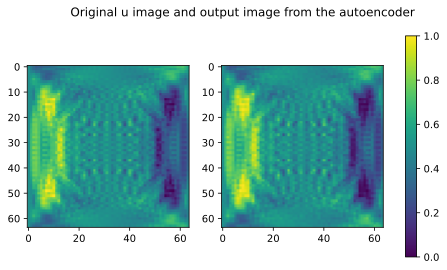

In [15]:
u_data.eval()
loader = DataLoader(dataset=u_data, batch_size=1, shuffle=True)

u_cae = u_cae.to("cpu")
u_cae.eval()
img1 = next(iter(loader))
with torch.no_grad():
    output1 = u_cae(img1)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

im1 = ax[0].imshow(torch.reshape(img1, (64, 64)))
im2 = ax[1].imshow(torch.reshape(output1.detach(), (64, 64)))

# Create a ScalarMappable object with the colormap from images
sm = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
fig.colorbar(sm, ax=ax, orientation="vertical")
fig.suptitle("Original u image and output image from the autoencoder")
plt.show()

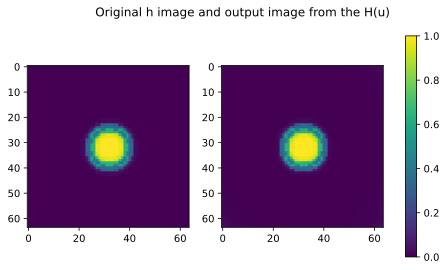

In [16]:
map_data.eval()
loader = DataLoader(dataset=map_data, batch_size=1, shuffle=True)

H_model = H_model.to("cpu")
img2, out2 = next(iter(loader))
H_model.eval()
with torch.no_grad():
    output2 = H_model(img2)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

im1 = ax[0].imshow(torch.reshape(out2, (64, 64)))
im2 = ax[1].imshow(torch.reshape(output2.detach(), (64, 64)))

# Create a ScalarMappable object with the colormap from images
sm = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
fig.colorbar(sm, ax=ax, orientation="vertical")
fig.suptitle("Original h image and output image from the H(u)")
plt.show()

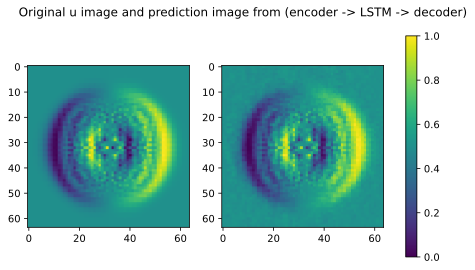

In [17]:
lstm_data = SeqDataset("data", folder="u_64R_8000", seq_length=2)
lstm_data.train()
loader = DataLoader(dataset=lstm_data, batch_size=1, shuffle=True)

u_encoder = u_cae.encoder.to("cpu")
u_encoder.eval()
u_decoder = u_cae.decoder.to("cpu")
u_decoder.eval()
lstm_model = lstm_model.to("cpu")
lstm_model.eval()
seqs = next(iter(loader))
with torch.no_grad():
    in_seqs = torch.stack(
        [u_encoder(seqs[:, j, :, :, :]) for j in range(1)]
    ).transpose(0, 1)
    in_seqs = in_seqs[:1]
    out = lstm_model(in_seqs)
    output3 = u_decoder(out[:, -1, :])

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

im1 = ax[0].imshow(torch.reshape(seqs[:, -1, :, :, :], (64, 64)))
im2 = ax[1].imshow(torch.reshape(output3.detach(), (64, 64)))

# Create a ScalarMappable object with the colormap from images
sm = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
fig.colorbar(sm, ax=ax, orientation="vertical")
fig.suptitle("Original u image and prediction image from (encoder -> LSTM -> decoder)")
plt.show()

In [18]:
idx_offset = 0
for i in range(1, 21):
    old = out
    out = lstm_model(old)
    no_change = torch.allclose(out, old)
    if not no_change:
        idx_offset = lstm_model.out_seq_length * i
    print(f"{no_change=} ========================> {i=}")

no_change=False ========================> i=1
no_change=True ========================> i=2
no_change=True ========================> i=3
no_change=True ========================> i=4
no_change=True ========================> i=5
no_change=True ========================> i=6
no_change=True ========================> i=7
no_change=True ========================> i=8
no_change=True ========================> i=9
no_change=True ========================> i=10
no_change=True ========================> i=11
no_change=True ========================> i=12
no_change=True ========================> i=13
no_change=True ========================> i=14
no_change=True ========================> i=15
no_change=True ========================> i=16
no_change=True ========================> i=17
no_change=True ========================> i=18
no_change=True ========================> i=19
no_change=True ========================> i=20


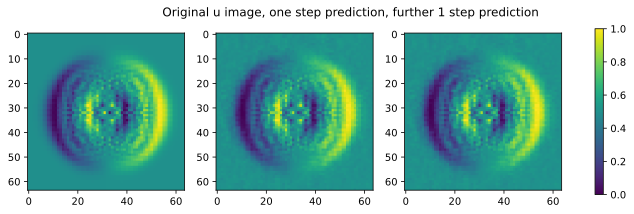

In [19]:
with torch.no_grad():
    output = u_decoder(out[:, -1, :])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

im1 = ax[0].imshow(torch.reshape(seqs[:, -1, :, :, :], (64, 64)))
ax[1].imshow(torch.reshape(output3.detach(), (64, 64)))
ax[2].imshow(torch.reshape(output.detach().cpu(), (64, 64)))

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Create a ScalarMappable object with the colormap from images
sm = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
fig.colorbar(sm, ax=ax, orientation="vertical")
n = idx_offset // lstm_model.out_seq_length
fig.suptitle(f"Original u image, one step prediction, further {n} step prediction")
plt.show()

# 3DVar and 4DVar

In [20]:
import deepda
from deepda import apply_3DVar, apply_4DVar

#### Test 3DVar

Iterations: 0, J: 17482743808.0, Norm of J gradient: 10494538752.0
Iterations: 1, J: 17062516736.0, Norm of J gradient: 13162109952.0
Iterations: 2, J: 16602349568.0, Norm of J gradient: 12611958784.0
Iterations: 3, J: 16241096704.0, Norm of J gradient: 10862706688.0
Iterations: 4, J: 15947507712.0, Norm of J gradient: 10261201920.0
Iterations: 5, J: 15673918464.0, Norm of J gradient: 10149558272.0
Iterations: 6, J: 15401603072.0, Norm of J gradient: 9758546944.0
Iterations: 7, J: 15142010880.0, Norm of J gradient: 10814049280.0
Iterations: 8, J: 14866548736.0, Norm of J gradient: 11651148800.0
Iterations: 9, J: 14573510656.0, Norm of J gradient: 11999137792.0
Iterations: 10, J: 14271483904.0, Norm of J gradient: 12092889088.0
Iterations: 11, J: 13976931328.0, Norm of J gradient: 11332716544.0
Iterations: 12, J: 13706017792.0, Norm of J gradient: 10416700416.0
Iterations: 13, J: 13464073216.0, Norm of J gradient: 10099287040.0
Iterations: 14, J: 13242990592.0, Norm of J gradient: 10529

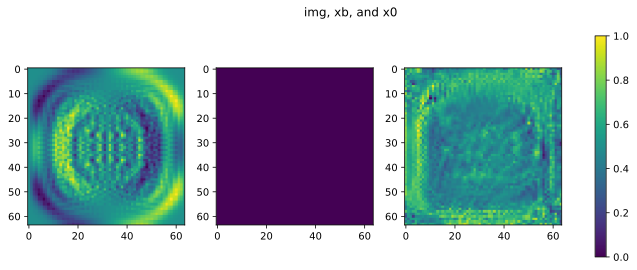

In [21]:
map_data.eval()
loader = DataLoader(dataset=map_data, batch_size=1, shuffle=True)

H_model = H_model.to(device)
img, out = next(iter(loader))
img, out = img.to(device), out.to(device)
H_model.eval()

B = torch.eye(64 * 64, device=device)
R = 1e-8 * torch.eye(64 * 64, device=device)
xb = torch.zeros_like(img, device=device)
x0, _ = apply_3DVar(H_model, B, R, xb, out, learning_rate=1.25e-3)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

im1 = ax[0].imshow(torch.reshape(img.cpu(), (64, 64)))
im2 = ax[1].imshow(torch.reshape(xb.cpu(), (64, 64)))
im3 = ax[2].imshow(torch.reshape(x0.cpu(), (64, 64)))

# Create a ScalarMappable object with the colormap from images
sm = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
fig.colorbar(sm, ax=ax, orientation="vertical")
fig.suptitle("img, xb, and x0")
plt.show()

### Example 1 (latent space u to full space h)
#### Apply 3DVar

In [22]:
def H(xf: torch.Tensor):
    xp = u_decoder(xf)
    return H_model(xp)


start_end_idxs = (1800, 2000)

B = torch.eye(32, device=device)
R = 1e-10 * torch.eye(64 * 64, device=device)

map_data = MapDataset("data", interval=1)
map_data.all()
y_loader = DataLoader(dataset=map_data, batch_size=1, shuffle=False)

lstm_model = lstm_model.to(device)
lstm_model.train()
H_model = H_model.to(device)
H_model.eval()
u_encoder = u_encoder.to(device)
u_encoder.eval()
u_decoder = u_decoder.to(device)
u_decoder.eval()

outs_3d_da = []

In [23]:
case_to_run = (
    deepda.CaseBuilder()
    .set_observation_model(H)
    .set_background_covariance_matrix(B)
    .set_observation_covariance_matrix(R)
    .set_learning_rate(5)
    .set_max_iterations(300)
    .set_algorithm(deepda.Algorithms.Var3D)
    .set_device(deepda.Device.GPU)
)

In [24]:
for i, (x_imgs, y_imgs) in enumerate(y_loader):
    if i < start_end_idxs[0]:
        continue
    elif i == start_end_idxs[-1] + 1:
        break
    print(i)
    if i == start_end_idxs[0]:
        out = u_encoder(x_imgs.to(device)).view(1, 1, 32)
        continue
    if (i % 50 == 0) and (i != start_end_idxs[-1]):
        y_imgs = y_imgs.to(device)
        # # y_imgs = [
        # #     transform(Image.open(f"data/h_full_8000/{i + 1}.png"))
        # #     for _ in range(i + 1, i + lstm_model.sequence_length + 1)
        # # ]
        # # y_imgs = torch.cat(y_imgs).to(device)
        # out, _ = apply_3DVar(H, B, R, out, y_imgs, learning_rate=5, max_iterations=300, record_log=True)
        case_to_run.set_background_state(out).set_observations(y_imgs)
        out = case_to_run.execute()["assimilated_background_state"]
    outs_3d_da.append(out)
    out = lstm_model(out)
    out = out[:, :1]
    print("===============================")

1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850


Iterations: 0, J: 283147010048.0, Norm of J gradient: 23527745536.0
Iterations: 1, J: 208690675712.0, Norm of J gradient: 22144770048.0
Iterations: 2, J: 116379353088.0, Norm of J gradient: 8432665088.0
Iterations: 3, J: 119044358144.0, Norm of J gradient: 6701981696.0
Iterations: 4, J: 128176947200.0, Norm of J gradient: 7784922624.0
Iterations: 5, J: 117989187584.0, Norm of J gradient: 7114220032.0
Iterations: 6, J: 99174203392.0, Norm of J gradient: 5374459392.0
Iterations: 7, J: 84758528000.0, Norm of J gradient: 4843616768.0
Iterations: 8, J: 74331414528.0, Norm of J gradient: 4011916288.0
Iterations: 9, J: 71106084864.0, Norm of J gradient: 3981536768.0
Iterations: 10, J: 65825288192.0, Norm of J gradient: 3929793536.0
Iterations: 11, J: 63950573568.0, Norm of J gradient: 3269250048.0
Iterations: 12, J: 63356018688.0, Norm of J gradient: 3666886400.0
Iterations: 13, J: 57798160384.0, Norm of J gradient: 3870221312.0
Iterations: 14, J: 55453855744.0, Norm of J gradient: 5926894592

1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900


Iterations: 1, J: 97208844288.0, Norm of J gradient: 9438602240.0
Iterations: 2, J: 90314072064.0, Norm of J gradient: 4011227136.0
Iterations: 3, J: 91774861312.0, Norm of J gradient: 4371526656.0
Iterations: 4, J: 75592089600.0, Norm of J gradient: 4483676672.0
Iterations: 5, J: 60090933248.0, Norm of J gradient: 3236742400.0
Iterations: 6, J: 58260488192.0, Norm of J gradient: 2754419456.0
Iterations: 7, J: 69173362688.0, Norm of J gradient: 4493961728.0
Iterations: 8, J: 69266300928.0, Norm of J gradient: 4569046016.0
Iterations: 9, J: 59227283456.0, Norm of J gradient: 3623116800.0
Iterations: 10, J: 46648352768.0, Norm of J gradient: 2612394240.0
Iterations: 11, J: 41710592000.0, Norm of J gradient: 2019529984.0
Iterations: 12, J: 42178646016.0, Norm of J gradient: 3326917888.0
Iterations: 13, J: 43711352832.0, Norm of J gradient: 4497402880.0
Iterations: 14, J: 38971322368.0, Norm of J gradient: 2801491456.0
Iterations: 15, J: 38344892416.0, Norm of J gradient: 2942910464.0
Iter

1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950


Iterations: 1, J: 210976243712.0, Norm of J gradient: 14084160512.0
Iterations: 2, J: 128503398400.0, Norm of J gradient: 8780187648.0
Iterations: 3, J: 84705320960.0, Norm of J gradient: 6767361536.0
Iterations: 4, J: 66572771328.0, Norm of J gradient: 5902141952.0
Iterations: 5, J: 80054083584.0, Norm of J gradient: 6641915904.0
Iterations: 6, J: 90332241920.0, Norm of J gradient: 8076517376.0
Iterations: 7, J: 77736361984.0, Norm of J gradient: 5920819200.0
Iterations: 8, J: 62998593536.0, Norm of J gradient: 3571684864.0
Iterations: 9, J: 56010022912.0, Norm of J gradient: 2767570432.0
Iterations: 10, J: 53501980672.0, Norm of J gradient: 2778247424.0
Iterations: 11, J: 54902681600.0, Norm of J gradient: 3674096384.0
Iterations: 12, J: 54222376960.0, Norm of J gradient: 3960385792.0
Iterations: 13, J: 48697323520.0, Norm of J gradient: 3427003904.0
Iterations: 14, J: 41874542592.0, Norm of J gradient: 2359618304.0
Iterations: 15, J: 37831000064.0, Norm of J gradient: 2287322112.0
I

1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


In [25]:
map_data = MapDataset("data", interval=1)
map_data.all()
y_loader = DataLoader(dataset=map_data, batch_size=1, shuffle=False)

outs_no_3d_da = []
with torch.no_grad():
    for i, (x_imgs, _) in enumerate(y_loader):
        if i < start_end_idxs[0]:
            continue
        elif i == start_end_idxs[-1] + 1:
            break
        print(i)
        if i == start_end_idxs[0]:
            out = u_encoder(x_imgs.to(device)).view(1, 1, 32)
            continue
        outs_no_3d_da.append(out)
        out = lstm_model(out)
        out = out[:, :1]
        print("===============================")

1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [26]:
outs_no_3d_da_sames = [torch.allclose(outs_no_3d_da[i-1], outs_no_3d_da[i]) for i in range(1, len(outs_no_3d_da))]
outs_3d_da_sames = [torch.allclose(outs_3d_da[i-1], outs_3d_da[i]) for i in range(1, len(outs_3d_da))]
sum(outs_no_3d_da_sames), sum(outs_3d_da_sames)

(0, 96)

In [27]:
# diffs = []
diffs_da_real_mse = []
diffs_noda_real_mse = []
diffs_da_real_rrmse = []
diffs_noda_real_rrmse = []
diffs_da_real_ssim = []
diffs_noda_real_ssim = []

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

u_decoder = u_decoder.to("cpu")
u_decoder.eval()
with torch.no_grad():
    for i, (no_da, da) in enumerate(zip(outs_no_3d_da, outs_3d_da), start=start_end_idxs[0]):
        no_da, da = no_da.to("cpu"), da.to("cpu")
        # diff = ((u_decoder(no_da[:, 0, :]) - u_decoder(da[:, 0, :])) ** 2).sum()
        # diffs.append(diff)
        real_img = transform(Image.open(f"data/u_64R_8000/{i}.png")).view(64, 64)
        da_img = u_decoder(da).view(64, 64)
        noda_img = u_decoder(no_da).view(64, 64)
        da_minus_real_img_square = (da_img - real_img) ** 2
        noda_minus_real_img_square = (noda_img - real_img) ** 2
        # diff_da_real = da_minus_real_img_square.sum()
        # diff_noda_real = noda_minus_real_img_square.sum()
        diffs_da_real_mse.append(da_minus_real_img_square.mean())
        diffs_noda_real_mse.append(noda_minus_real_img_square.mean())

        diffs_da_real_rrmse.append((da_minus_real_img_square.sum()/((real_img**2).sum())).sqrt())
        diffs_noda_real_rrmse.append((noda_minus_real_img_square.sum()/((real_img**2).sum())).sqrt())

        diffs_da_real_ssim.append(ssim(real_img.numpy(), da_img.numpy(), data_range=1))
        diffs_noda_real_ssim.append(ssim(real_img.numpy(), noda_img.numpy(), data_range=1))

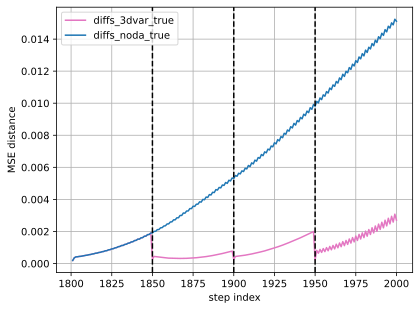

diffs_noda_real_mse[da_idxs[0]]=tensor(0.0019), diffs_noda_real_mse[da_idxs[1]]=tensor(0.0053), diffs_noda_real_mse[da_idxs[2]]=tensor(0.0098)
diffs_da_real_mse[da_idxs[0]]=tensor(0.0003), diffs_da_real_mse[da_idxs[1]]=tensor(0.0003), diffs_da_real_mse[da_idxs[2]]=tensor(0.0002)
diffs_noda_real_rrmse[da_idxs[0]]=tensor(0.0830), diffs_noda_real_rrmse[da_idxs[1]]=tensor(0.1382), diffs_noda_real_rrmse[da_idxs[2]]=tensor(0.1881)
diffs_da_real_rrmse[da_idxs[0]]=tensor(0.0316), diffs_da_real_rrmse[da_idxs[1]]=tensor(0.0308), diffs_da_real_rrmse[da_idxs[2]]=tensor(0.0290)
diffs_noda_real_ssim[da_idxs[0]]=0.8974395071496295, diffs_noda_real_ssim[da_idxs[1]]=0.7700207779647984, diffs_noda_real_ssim[da_idxs[2]]=0.6080241272353645
diffs_da_real_ssim[da_idxs[0]]=0.9726203978416044, diffs_da_real_ssim[da_idxs[1]]=0.9707089616306896, diffs_da_real_ssim[da_idxs[2]]=0.9745228041437378


In [28]:
step_idxs = list(range(start_end_idxs[0] + 1, start_end_idxs[-1] + 1))
da_points = [1850, 1900, 1950]

plt.plot(step_idxs, diffs_da_real_mse, color="#e377c2", label="diffs_3dvar_true")
plt.plot(step_idxs, diffs_noda_real_mse, color="#1f77b4", label="diffs_noda_true")
for x in da_points:
    plt.axvline(x=x, color="k", linestyle="--")
plt.xlabel("step index")
plt.ylabel("MSE distance")
plt.grid(True)
plt.legend()

plt.show()

da_idxs = [49, 99, 149]
print(f"{diffs_noda_real_mse[da_idxs[0]]=}, {diffs_noda_real_mse[da_idxs[1]]=}, {diffs_noda_real_mse[da_idxs[2]]=}")
print(f"{diffs_da_real_mse[da_idxs[0]]=}, {diffs_da_real_mse[da_idxs[1]]=}, {diffs_da_real_mse[da_idxs[2]]=}")
print(f"{diffs_noda_real_rrmse[da_idxs[0]]=}, {diffs_noda_real_rrmse[da_idxs[1]]=}, {diffs_noda_real_rrmse[da_idxs[2]]=}")
print(f"{diffs_da_real_rrmse[da_idxs[0]]=}, {diffs_da_real_rrmse[da_idxs[1]]=}, {diffs_da_real_rrmse[da_idxs[2]]=}")
print(f"{diffs_noda_real_ssim[da_idxs[0]]=}, {diffs_noda_real_ssim[da_idxs[1]]=}, {diffs_noda_real_ssim[da_idxs[2]]=}")
print(f"{diffs_da_real_ssim[da_idxs[0]]=}, {diffs_da_real_ssim[da_idxs[1]]=}, {diffs_da_real_ssim[da_idxs[2]]=}")

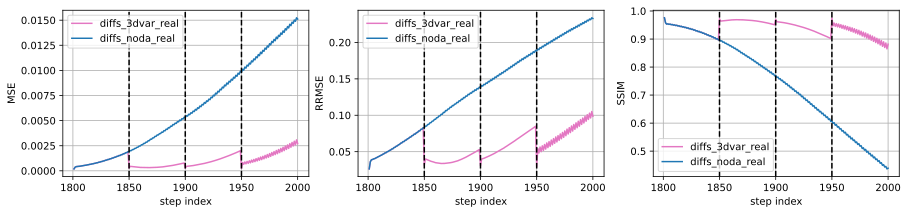

In [29]:
step_idxs = list(range(start_end_idxs[0] + 1, start_end_idxs[-1] + 1))
da_points = [1850, 1900, 1950]

_, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].plot(step_idxs, diffs_da_real_mse, color="#e377c2", label="diffs_3dvar_real")
ax[0].plot(step_idxs, diffs_noda_real_mse, color="#1f77b4", label="diffs_noda_real")

ax[1].plot(step_idxs, diffs_da_real_rrmse, color="#e377c2", label="diffs_3dvar_real")
ax[1].plot(step_idxs, diffs_noda_real_rrmse, color="#1f77b4", label="diffs_noda_real")

ax[2].plot(step_idxs, diffs_da_real_ssim, color="#e377c2", label="diffs_3dvar_real")
ax[2].plot(step_idxs, diffs_noda_real_ssim, color="#1f77b4", label="diffs_noda_real")

for i, name in enumerate(["MSE", "RRMSE", "SSIM"]):
    ax[i].set_xlabel("step index")
    ax[i].set_ylabel(name)
    ax[i].grid(True)
    ax[i].legend()
    for x in da_points:
        ax[i].axvline(x=x, color="k", linestyle="--")

plt.show()

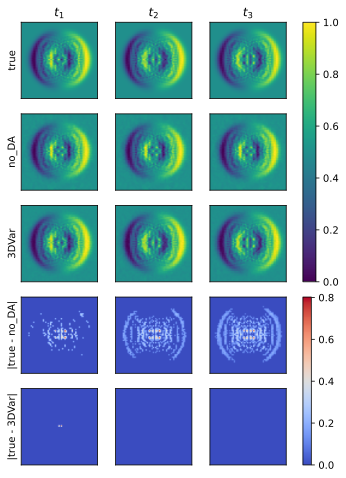

In [30]:
da_idxs = [49, 99, 149]

fig, ax = plt.subplots(5, len(da_idxs), figsize=(2 * len(da_idxs), 8), sharex=True)
for x in ax.flat:
    x.set_xticks([])
    x.set_yticks([])
    x.set_xticklabels([])
    x.set_yticklabels([])
# outs --> no DA list [39, Shape([1, 5, 32])]
# outs_da --> has DA list [39, Shape([1, 5, 32])]

u_decoder = u_decoder.to(device)
u_decoder.eval()
setup_cmap = True
with torch.no_grad():
    for i, da_idx in enumerate(da_idxs):
        img_tensor = transform(
            Image.open(
                f"data/u_64R_8000/{da_points[i]}.png"
            )
        )
        im1 = ax[0, i].imshow(torch.reshape(img_tensor, (64, 64)), origin="lower", cmap="viridis")
        if setup_cmap:
            # Create a ScalarMappable object with the colormap from images
            sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)
        no_da = u_decoder(outs_no_3d_da[da_idx][:, 0]).cpu()
        da = u_decoder(outs_3d_da[da_idx][:, 0]).cpu()
        ax[1, i].imshow(torch.reshape(no_da, (64, 64)), origin="lower", cmap="viridis")
        ax[2, i].imshow(torch.reshape(da, (64, 64)), origin="lower", cmap="viridis")
        res = (img_tensor.reshape((64, 64)) - no_da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        im2 = ax[3, i].imshow(res, origin="lower", cmap="coolwarm")
        if setup_cmap:
            sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
        res = (img_tensor.reshape((64, 64)) - da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        ax[4, i].imshow(res, origin="lower", cmap="coolwarm")
        setup_cmap = False

for i, title in enumerate(["$t_1$", "$t_2$", "$t_3$"]):
    ax[0, i].set_title(title)

for i, ylabel in enumerate(["true", "no_DA", "3DVar", "|true - no_DA|", "|true - 3DVar|"]):
    ax[i, 0].set_ylabel(ylabel)

# # Create a ScalarMappable object with the colormap from images
# sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm1.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
# fig.colorbar(sm1, ax=ax, orientation="vertical")

fig.colorbar(sm1, ax=ax[:-2, :], orientation="vertical")
sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[-2:, :], orientation="vertical")

plt.show()

### Example 2 (latent space x to latent space y)
#### With Reduce Order `M` (With ROM)
#### Apply 3DVar

In [31]:
def H(x: torch.Tensor):
    x = u_decoder(x)
    x = H_model(x)
    return h_encoder(x)


start_end_idxs = (1800, 2000)

B = torch.eye(32, device=device)
R = 1e-10 * torch.eye(32, device=device)

map_data = MapDataset("data", interval=1)
map_data.all()
y_loader = DataLoader(dataset=map_data, batch_size=1, shuffle=False)

h_cae = CAE(Encoder(), Decoder())
h_cae.load_state_dict(torch.load("h_cae.pt", map_location="cpu"))
h_encoder = h_cae.encoder.to(device)
h_encoder.eval()
lstm_model = lstm_model.to(device)
lstm_model.train()
H_model = H_model.to(device)
H_model.eval()
u_encoder = u_encoder.to(device)
u_encoder.eval()
u_decoder = u_decoder.to(device)
u_decoder.eval()

outs_3d_da = []

In [32]:
case_to_run.set_observation_model(H).set_background_covariance_matrix(
    B
).set_observation_covariance_matrix(R).set_learning_rate(5).set_max_iterations(
    300
).set_algorithm(
    deepda.Algorithms.Var3D
)

Parameters for Case: case_2023-08-30T13-16-42.097105
--------------------------------------
algorithm:
Algorithms.Var3D

device:
Device.GPU

observation_model:
<function H at 0x7f79eafee170>

background_covariance_matrix:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

observation_covariance_matrix:
tensor([[1.0000e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.0000e-10, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e-10,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0000e-10,

In [33]:
for i, (x_imgs, y_imgs) in enumerate(y_loader):
    if i < start_end_idxs[0]:
        continue
    elif i == start_end_idxs[-1] + 1:
        break
    print(i)
    if i == start_end_idxs[0]:
        out = u_encoder(x_imgs.to(device)).view(1, 1, 32)
        continue
    if (i % 50 == 0) and (i != start_end_idxs[-1]):
        y_latent = h_encoder(y_imgs.to(device)).view(1, 1, 32)
        # out, _ = apply_3DVar(H, B, R, out, y_imgs, learning_rate=5, max_iterations=300, record_log=True)
        case_to_run.set_background_state(out).set_observations(y_latent)
        out = case_to_run.execute()["assimilated_background_state"]
    outs_3d_da.append(out)
    out = lstm_model(out)
    out = out[:, :1]
    print("===============================")

1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850


Iterations: 0, J: 8071769227264.0, Norm of J gradient: 950355361792.0
Iterations: 1, J: 8627288014848.0, Norm of J gradient: 1185050394624.0
Iterations: 2, J: 5579710922752.0, Norm of J gradient: 478742315008.0
Iterations: 3, J: 4855078846464.0, Norm of J gradient: 657424580608.0
Iterations: 4, J: 2757043159040.0, Norm of J gradient: 248609456128.0
Iterations: 5, J: 3220779565056.0, Norm of J gradient: 276938555392.0
Iterations: 6, J: 3937809203200.0, Norm of J gradient: 413429268480.0
Iterations: 7, J: 3435981176832.0, Norm of J gradient: 346707689472.0
Iterations: 8, J: 2460806545408.0, Norm of J gradient: 254850908160.0
Iterations: 9, J: 1896864153600.0, Norm of J gradient: 157049421824.0
Iterations: 10, J: 1740048171008.0, Norm of J gradient: 246340599808.0
Iterations: 11, J: 1608758853632.0, Norm of J gradient: 166348898304.0
Iterations: 12, J: 1610994548736.0, Norm of J gradient: 207745826816.0
Iterations: 13, J: 1522757926912.0, Norm of J gradient: 149859090432.0
Iterations: 14,

1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900


Iterations: 9, J: 1348541743104.0, Norm of J gradient: 184361189376.0
Iterations: 10, J: 1155890937856.0, Norm of J gradient: 164641669120.0
Iterations: 11, J: 935455686656.0, Norm of J gradient: 141224984576.0
Iterations: 12, J: 956003647488.0, Norm of J gradient: 156939403264.0
Iterations: 13, J: 1002044784640.0, Norm of J gradient: 166096830464.0
Iterations: 14, J: 858291961856.0, Norm of J gradient: 133217665024.0
Iterations: 15, J: 704608272384.0, Norm of J gradient: 116614823936.0
Iterations: 16, J: 580705648640.0, Norm of J gradient: 99717283840.0
Iterations: 17, J: 446937366528.0, Norm of J gradient: 61371691008.0
Iterations: 18, J: 417957838848.0, Norm of J gradient: 38196740096.0
Iterations: 19, J: 435342606336.0, Norm of J gradient: 69148221440.0
Iterations: 20, J: 477473865728.0, Norm of J gradient: 93688086528.0
Iterations: 21, J: 450134999040.0, Norm of J gradient: 77651607552.0
Iterations: 22, J: 387980984320.0, Norm of J gradient: 48787406848.0
Iterations: 23, J: 373435

1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950


Iterations: 9, J: 898517434368.0, Norm of J gradient: 115034497024.0
Iterations: 10, J: 876356698112.0, Norm of J gradient: 102104309760.0
Iterations: 11, J: 870726369280.0, Norm of J gradient: 141683113984.0
Iterations: 12, J: 714379886592.0, Norm of J gradient: 96223821824.0
Iterations: 13, J: 635510456320.0, Norm of J gradient: 80453173248.0
Iterations: 14, J: 556736577536.0, Norm of J gradient: 64909901824.0
Iterations: 15, J: 502435348480.0, Norm of J gradient: 49712439296.0
Iterations: 16, J: 541651369984.0, Norm of J gradient: 114136571904.0
Iterations: 17, J: 492895764480.0, Norm of J gradient: 108592218112.0
Iterations: 18, J: 369014374400.0, Norm of J gradient: 78665547776.0
Iterations: 19, J: 296815755264.0, Norm of J gradient: 75200610304.0
Iterations: 20, J: 241641717760.0, Norm of J gradient: 63762034688.0
Iterations: 21, J: 203563433984.0, Norm of J gradient: 42082226176.0
Iterations: 22, J: 226306785280.0, Norm of J gradient: 67529437184.0
Iterations: 23, J: 23106666496

1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


In [34]:
map_data = MapDataset("data", interval=1)
map_data.all()
y_loader = DataLoader(dataset=map_data, batch_size=1, shuffle=False)

outs_no_3d_da = []
with torch.no_grad():
    for i, (x_imgs, _) in enumerate(y_loader):
        if i < start_end_idxs[0]:
            continue
        elif i == start_end_idxs[-1] + 1:
            break
        print(i)
        if i == start_end_idxs[0]:
            out = u_encoder(x_imgs.to(device)).view(1, 1, 32)
            continue
        outs_no_3d_da.append(out)
        out = lstm_model(out)
        out = out[:, :1]
        print("===============================")

1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [35]:
outs_no_3d_da_sames = [torch.allclose(outs_no_3d_da[i-1], outs_no_3d_da[i]) for i in range(1, len(outs_no_3d_da))]
outs_3d_da_sames = [torch.allclose(outs_3d_da[i-1], outs_3d_da[i]) for i in range(1, len(outs_3d_da))]
sum(outs_no_3d_da_sames), sum(outs_3d_da_sames)

(0, 95)

In [36]:
# diffs = []
diffs_da_real_mse = []
diffs_noda_real_mse = []
diffs_da_real_rrmse = []
diffs_noda_real_rrmse = []
diffs_da_real_ssim = []
diffs_noda_real_ssim = []

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

u_decoder = u_decoder.to("cpu")
u_decoder.eval()
with torch.no_grad():
    for i, (no_da, da) in enumerate(zip(outs_no_3d_da, outs_3d_da), start=start_end_idxs[0]):
        no_da, da = no_da.to("cpu"), da.to("cpu")
        # diff = ((u_decoder(no_da[:, 0, :]) - u_decoder(da[:, 0, :])) ** 2).sum()
        # diffs.append(diff)
        real_img = transform(Image.open(f"data/u_64R_8000/{i}.png")).view(64, 64)
        da_img = u_decoder(da).view(64, 64)
        noda_img = u_decoder(no_da).view(64, 64)
        da_minus_real_img_square = (da_img - real_img) ** 2
        noda_minus_real_img_square = (noda_img - real_img) ** 2
        # diff_da_real = da_minus_real_img_square.sum()
        # diff_noda_real = noda_minus_real_img_square.sum()
        diffs_da_real_mse.append(da_minus_real_img_square.mean())
        diffs_noda_real_mse.append(noda_minus_real_img_square.mean())

        diffs_da_real_rrmse.append((da_minus_real_img_square.sum()/((real_img**2).sum())).sqrt())
        diffs_noda_real_rrmse.append((noda_minus_real_img_square.sum()/((real_img**2).sum())).sqrt())

        diffs_da_real_ssim.append(ssim(real_img.numpy(), da_img.numpy(), data_range=1))
        diffs_noda_real_ssim.append(ssim(real_img.numpy(), noda_img.numpy(), data_range=1))

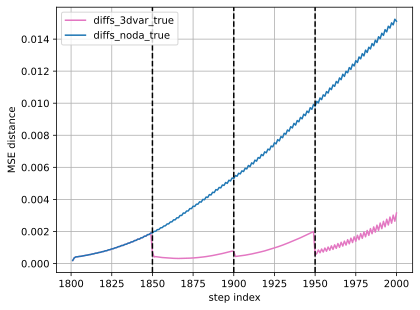

diffs_noda_real_mse[da_idxs[0]]=tensor(0.0019), diffs_noda_real_mse[da_idxs[1]]=tensor(0.0053), diffs_noda_real_mse[da_idxs[2]]=tensor(0.0098)
diffs_da_real_mse[da_idxs[0]]=tensor(0.0007), diffs_da_real_mse[da_idxs[1]]=tensor(0.0007), diffs_da_real_mse[da_idxs[2]]=tensor(0.0005)
diffs_noda_real_rrmse[da_idxs[0]]=tensor(0.0830), diffs_noda_real_rrmse[da_idxs[1]]=tensor(0.1382), diffs_noda_real_rrmse[da_idxs[2]]=tensor(0.1881)
diffs_da_real_rrmse[da_idxs[0]]=tensor(0.0507), diffs_da_real_rrmse[da_idxs[1]]=tensor(0.0518), diffs_da_real_rrmse[da_idxs[2]]=tensor(0.0443)
diffs_noda_real_ssim[da_idxs[0]]=0.8974395071496295, diffs_noda_real_ssim[da_idxs[1]]=0.7700207779647984, diffs_noda_real_ssim[da_idxs[2]]=0.6080241272353645
diffs_da_real_ssim[da_idxs[0]]=0.9473081940029804, diffs_da_real_ssim[da_idxs[1]]=0.9459179518268168, diffs_da_real_ssim[da_idxs[2]]=0.9572208718829717


In [37]:
step_idxs = list(range(start_end_idxs[0] + 1, start_end_idxs[-1] + 1))
da_points = [1850, 1900, 1950]

plt.plot(step_idxs, diffs_da_real_mse, color="#e377c2", label="diffs_3dvar_true")
plt.plot(step_idxs, diffs_noda_real_mse, color="#1f77b4", label="diffs_noda_true")
for x in da_points:
    plt.axvline(x=x, color="k", linestyle="--")
plt.xlabel("step index")
plt.ylabel("MSE distance")
plt.grid(True)
plt.legend()

plt.show()

da_idxs = [49, 99, 149]
print(f"{diffs_noda_real_mse[da_idxs[0]]=}, {diffs_noda_real_mse[da_idxs[1]]=}, {diffs_noda_real_mse[da_idxs[2]]=}")
print(f"{diffs_da_real_mse[da_idxs[0]]=}, {diffs_da_real_mse[da_idxs[1]]=}, {diffs_da_real_mse[da_idxs[2]]=}")
print(f"{diffs_noda_real_rrmse[da_idxs[0]]=}, {diffs_noda_real_rrmse[da_idxs[1]]=}, {diffs_noda_real_rrmse[da_idxs[2]]=}")
print(f"{diffs_da_real_rrmse[da_idxs[0]]=}, {diffs_da_real_rrmse[da_idxs[1]]=}, {diffs_da_real_rrmse[da_idxs[2]]=}")
print(f"{diffs_noda_real_ssim[da_idxs[0]]=}, {diffs_noda_real_ssim[da_idxs[1]]=}, {diffs_noda_real_ssim[da_idxs[2]]=}")
print(f"{diffs_da_real_ssim[da_idxs[0]]=}, {diffs_da_real_ssim[da_idxs[1]]=}, {diffs_da_real_ssim[da_idxs[2]]=}")

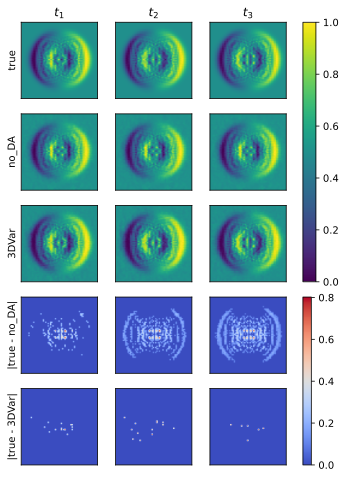

In [38]:
da_idxs = [49, 99, 149]

fig, ax = plt.subplots(5, len(da_idxs), figsize=(2 * len(da_idxs), 8), sharex=True)
for x in ax.flat:
    x.set_xticks([])
    x.set_yticks([])
    x.set_xticklabels([])
    x.set_yticklabels([])
# outs --> no DA list [39, Shape([1, 5, 32])]
# outs_da --> has DA list [39, Shape([1, 5, 32])]

u_decoder = u_decoder.to(device)
u_decoder.eval()
setup_cmap = True
with torch.no_grad():
    for i, da_idx in enumerate(da_idxs):
        img_tensor = transform(
            Image.open(
                f"data/u_64R_8000/{da_points[i]}.png"
            )
        )
        im1 = ax[0, i].imshow(torch.reshape(img_tensor, (64, 64)), origin="lower", cmap="viridis")
        if setup_cmap:
            # Create a ScalarMappable object with the colormap from images
            sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)
        no_da = u_decoder(outs_no_3d_da[da_idx][:, 0]).cpu()
        da = u_decoder(outs_3d_da[da_idx][:, 0]).cpu()
        ax[1, i].imshow(torch.reshape(no_da, (64, 64)), origin="lower", cmap="viridis")
        ax[2, i].imshow(torch.reshape(da, (64, 64)), origin="lower", cmap="viridis")
        res = (img_tensor.reshape((64, 64)) - no_da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        im2 = ax[3, i].imshow(res, origin="lower", cmap="coolwarm")
        if setup_cmap:
            sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
        res = (img_tensor.reshape((64, 64)) - da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        ax[4, i].imshow(res, origin="lower", cmap="coolwarm")
        setup_cmap = False

for i, title in enumerate(["$t_1$", "$t_2$", "$t_3$"]):
    ax[0, i].set_title(title)

for i, ylabel in enumerate(["true", "no_DA", "3DVar", "|true - no_DA|", "|true - 3DVar|"]):
    ax[i, 0].set_ylabel(ylabel)

# # Create a ScalarMappable object with the colormap from images
# sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm1.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
# fig.colorbar(sm1, ax=ax, orientation="vertical")

fig.colorbar(sm1, ax=ax[:-2, :], orientation="vertical")
sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[-2:, :], orientation="vertical")

plt.show()

### Example 3 (latent space x to full space y)
#### Apply 4DVar

In [39]:
start_da_end_idxs = (1800, 1900, 2000)

time_obs = [
    start_da_end_idxs[1],
    start_da_end_idxs[1] + 10,
]
gaps = [10] * (len(time_obs) - 1)

map_data = MapDataset("data", y_folder="h_full_8000", interval=1)
map_data.all()
y_loader = DataLoader(dataset=map_data, batch_size=1, shuffle=False)

y_data = [
    y_imgs.to(device)
    for i, (_, y_imgs) in enumerate(y_loader)
    if i in time_obs
]

y_data = torch.cat(y_data).to(device)

In [40]:
def H(xf: torch.Tensor):
    xp = u_decoder(xf)
    return H_model(xp)


# def M(x: torch.Tensor, time_fw: torch.Tensor, *args):
#     # for _ in time_fw[:-1]:
#     #     x = lstm_model(x)
#     # return x
#     outs = [x0.view(1, -1) if (x0:=x).ndim == 1 else x]
#     x = outs[0]
#     forward_times, residue = divmod(len(time_fw[:-1]), lstm_model.out_seq_length)
#     for _ in range(forward_times+1):
#         x = lstm_model(x)
#         outs.append(x)
#         x = x[-1]
#     outs[-1] = outs[-1][:residue]
#     return torch.cat(outs)


B = torch.eye(32, device=device)
R = 1e-10 * torch.eye(64 * 64, device=device)

lstm_model = lstm_model.to(device)
lstm_model.train()
H_model = H_model.to(device)
H_model.eval()
u_encoder = u_encoder.to(device)
u_encoder.eval()
u_decoder = u_decoder.to(device)
u_decoder.eval()

y_loader = DataLoader(dataset=map_data, batch_size=1, shuffle=False)
outs_4d_da = []

In [41]:
case_to_run = (
    deepda.CaseBuilder()
    .set_observation_time_steps(time_obs)
    .set_gaps(gaps)
    .set_forward_model(lstm_model)
    .set_observation_model(H)
    .set_background_covariance_matrix(B)
    .set_observation_covariance_matrix(R)
    .set_observations(y_data)
    .set_learning_rate(2.5)
    .set_max_iterations(100)
    .set_algorithm(deepda.Algorithms.Var4D)
    .set_device(deepda.Device.GPU)
    .set_output_sequence_length(lstm_model.out_seq_length)
)

In [42]:
for i, (x_imgs, y_imgs) in enumerate(y_loader):
    if i < start_da_end_idxs[0]:
        continue
    elif i == start_da_end_idxs[-1] + 1:
        outs_4d_da.append(out)
        break
    print(i)
    if i == start_da_end_idxs[0]:
        out = u_encoder(x_imgs.to(device)).view(1, 1, 32)
        continue
    if i == start_da_end_idxs[1]:
        case_to_run.set_background_state(out.ravel())
        out = case_to_run.execute()["assimilated_background_state"].view(1, 1, 32)
        # out, _ = apply_4DVar(
        #     time_obs,
        #     gaps,
        #     M,
        #     H,
        #     B,
        #     R,
        #     out,
        #     y_data,
        #     learning_rate=2.5,
        #     record_log=True,
        #     max_iterations=100,
        # )
    outs_4d_da.append(out)
    out = lstm_model(out)
    out = out[:, :1]
    print("===============================")

1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900


Iterations: 0, Jb: 476953051136.0, Jo: 481270923264.0, J: 958224007168.0, Norm of J gradient: 28914894848.0
Iterations: 1, Jb: 279238705152.0, Jo: 380817833984.0, J: 660056571904.0, Norm of J gradient: 14031233024.0
Iterations: 2, Jb: 222091051008.0, Jo: 380817833984.0, J: 602908917760.0, Norm of J gradient: 15923390464.0
Iterations: 3, Jb: 186596245504.0, Jo: 380817833984.0, J: 567414095872.0, Norm of J gradient: 8368494080.0
Iterations: 4, Jb: 181977776128.0, Jo: 380817899520.0, J: 562795642880.0, Norm of J gradient: 8000297472.0
Iterations: 5, Jb: 174323515392.0, Jo: 380817866752.0, J: 555141365760.0, Norm of J gradient: 7500957184.0
Iterations: 6, Jb: 166911148032.0, Jo: 258948415488.0, J: 425859547136.0, Norm of J gradient: 7671618048.0
Iterations: 7, Jb: 159921045504.0, Jo: 258948431872.0, J: 418869477376.0, Norm of J gradient: 8557567488.0
Iterations: 8, Jb: 149346828288.0, Jo: 258948415488.0, J: 408295243776.0, Norm of J gradient: 7512988672.0
Iterations: 9, Jb: 137449897984.0,

1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


In [43]:
map_data = MapDataset("data", interval=1)
map_data.all()
y_loader = DataLoader(dataset=map_data, batch_size=1, shuffle=False)

outs_no_4d_da = []
with torch.no_grad():
    for i, (x_imgs, _) in enumerate(y_loader):
        if i < start_da_end_idxs[0]:
            continue
        elif i == start_da_end_idxs[-1] + 1:
            break
        print(i)
        if i == start_da_end_idxs[0]:
            out = u_encoder(x_imgs.to(device)).view(1, 1, 32)
            continue
        outs_no_4d_da.append(out)
        out = lstm_model(out)
        out = out[:, :1]
        print("===============================")

1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [44]:
# diffs = []
diffs_da_real_mse = []
diffs_noda_real_mse = []
diffs_da_real_rrmse = []
diffs_noda_real_rrmse = []
diffs_da_real_ssim = []
diffs_noda_real_ssim = []

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

u_decoder = u_decoder.to("cpu")
u_decoder.eval()
with torch.no_grad():
    for i, (no_da, da) in enumerate(zip(outs_no_4d_da, outs_4d_da), start=start_da_end_idxs[0]):
        no_da, da = no_da.to("cpu"), da.to("cpu")
        # diff = ((u_decoder(no_da[:, 0, :]) - u_decoder(da[:, 0, :])) ** 2).sum()
        # diffs.append(diff)
        real_img = transform(Image.open(f"data/u_64R_8000/{i}.png")).view(64, 64)
        da_img = u_decoder(da).view(64, 64)
        noda_img = u_decoder(no_da).view(64, 64)
        da_minus_real_img_square = (da_img - real_img) ** 2
        noda_minus_real_img_square = (noda_img - real_img) ** 2
        # diff_da_real = da_minus_real_img_square.sum()
        # diff_noda_real = noda_minus_real_img_square.sum()
        diffs_da_real_mse.append(da_minus_real_img_square.mean())
        diffs_noda_real_mse.append(noda_minus_real_img_square.mean())

        diffs_da_real_rrmse.append((da_minus_real_img_square.sum()/((real_img**2).sum())).sqrt())
        diffs_noda_real_rrmse.append((noda_minus_real_img_square.sum()/((real_img**2).sum())).sqrt())

        diffs_da_real_ssim.append(ssim(real_img.numpy(), da_img.numpy(), data_range=1))
        diffs_noda_real_ssim.append(ssim(real_img.numpy(), noda_img.numpy(), data_range=1))

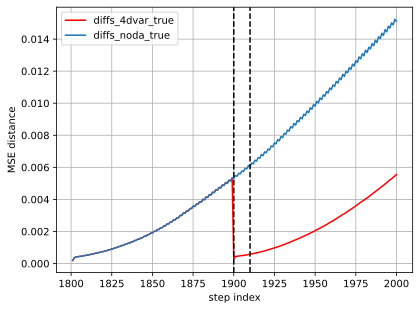

diffs_noda_real_mse[da_idxs[0]]=tensor(0.0053), diffs_noda_real_mse[da_idxs[1]]=tensor(0.0060)
diffs_da_real_mse[da_idxs[0]]=tensor(0.0003), diffs_da_real_mse[da_idxs[1]]=tensor(0.0006)
diffs_noda_real_rrmse[da_idxs[0]]=tensor(0.1382), diffs_noda_real_rrmse[da_idxs[1]]=tensor(0.1477)
diffs_da_real_rrmse[da_idxs[0]]=tensor(0.0318), diffs_da_real_rrmse[da_idxs[1]]=tensor(0.0456)
diffs_noda_real_ssim[da_idxs[0]]=0.7700207779647984, diffs_noda_real_ssim[da_idxs[1]]=0.7408145560704971
diffs_da_real_ssim[da_idxs[0]]=0.9696976279177648, diffs_da_real_ssim[da_idxs[1]]=0.9563728125675113


In [45]:
step_idxs = list(range(start_da_end_idxs[0] + 1, start_da_end_idxs[-1] + 1))

plt.plot(step_idxs, diffs_da_real_mse, color="r", label="diffs_4dvar_true")
plt.plot(step_idxs, diffs_noda_real_mse, color="#1f77b4", label="diffs_noda_true")
for x in time_obs:
    plt.axvline(x=x, color="k", linestyle="--")
plt.xlabel("step index")
plt.ylabel("MSE distance")
plt.grid(True)
plt.legend()

plt.show()

da_idxs = [99, 109]
print(f"{diffs_noda_real_mse[da_idxs[0]]=}, {diffs_noda_real_mse[da_idxs[1]]=}")
print(f"{diffs_da_real_mse[da_idxs[0]]=}, {diffs_da_real_mse[da_idxs[1]]=}")
print(f"{diffs_noda_real_rrmse[da_idxs[0]]=}, {diffs_noda_real_rrmse[da_idxs[1]]=}")
print(f"{diffs_da_real_rrmse[da_idxs[0]]=}, {diffs_da_real_rrmse[da_idxs[1]]=}")
print(f"{diffs_noda_real_ssim[da_idxs[0]]=}, {diffs_noda_real_ssim[da_idxs[1]]=}")
print(f"{diffs_da_real_ssim[da_idxs[0]]=}, {diffs_da_real_ssim[da_idxs[1]]=}")

In [46]:
# plt.plot(step_idxs, diffs, label="diffs_da_noda")
# for x in time_obs:
#     plt.axvline(x=x, color="k", linestyle="--")
# plt.xlabel("image index")
# plt.ylabel("MSE distance")
# plt.grid(True)
# plt.legend()

# plt.show()

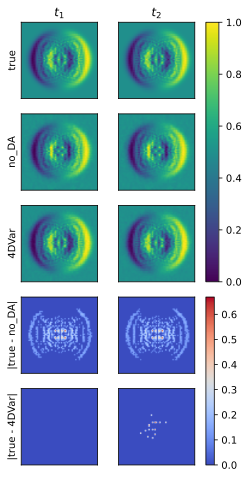

In [47]:
da_idxs = [99, 109]

fig, ax = plt.subplots(5, len(da_idxs), figsize=(2 * len(da_idxs), 8), sharex=True)
for x in ax.flat:
    x.set_xticks([])
    x.set_yticks([])
    x.set_xticklabels([])
    x.set_yticklabels([])
# outs --> no DA list [39, Shape([1, 5, 32])]
# outs_da --> has DA list [39, Shape([1, 5, 32])]

u_decoder = u_decoder.to(device)
u_decoder.eval()
setup_cmap = True
with torch.no_grad():
    for i, da_idx in enumerate(da_idxs):
        img_tensor = transform(
            Image.open(
                f"data/u_64R_8000/{time_obs[i]}.png"
            )
        )
        im1 = ax[0, i].imshow(torch.reshape(img_tensor, (64, 64)), origin="lower", cmap="viridis")
        if setup_cmap:
            # Create a ScalarMappable object with the colormap from images
            sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)
        no_da = u_decoder(outs_no_4d_da[da_idx][:, 0]).cpu()
        da = u_decoder(outs_4d_da[da_idx][:, 0]).cpu()
        ax[1, i].imshow(torch.reshape(no_da, (64, 64)), origin="lower", cmap="viridis")
        ax[2, i].imshow(torch.reshape(da, (64, 64)), origin="lower", cmap="viridis")
        res = (img_tensor.reshape((64, 64)) - no_da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        im2 = ax[3, i].imshow(res, origin="lower", cmap="coolwarm")
        if setup_cmap:
            sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
        res = (img_tensor.reshape((64, 64)) - da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        ax[4, i].imshow(res, origin="lower", cmap="coolwarm")
        setup_cmap = False

for i, title in enumerate(["$t_1$", "$t_2$"]):
    ax[0, i].set_title(title)
# ax[0].set_title("$t$")
for i, ylabel in enumerate(["true", "no_DA", "4DVar", "|true - no_DA|", "|true - 4DVar|"]):
    ax[i, 0].set_ylabel(ylabel)

# # Create a ScalarMappable object with the colormap from images
# sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm1.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
# fig.colorbar(sm1, ax=ax, orientation="vertical")

fig.colorbar(sm1, ax=ax[:-2, :], orientation="vertical")
sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[-2:, :], orientation="vertical")

plt.show()

### Example 4 (latent space x to latent space y)
#### With Reduce Order `M` (With ROM)
#### Apply 4DVar

In [48]:
start_da_end_idxs = (1800, 1900, 2000)

time_obs = [
    start_da_end_idxs[1],
    start_da_end_idxs[1] + 10,
]
gaps = [10] * (len(time_obs) - 1)

h_cae = CAE(Encoder(), Decoder())
h_cae.load_state_dict(torch.load("h_cae.pt", map_location="cpu"))
h_encoder = h_cae.encoder.to(device)
h_encoder.eval()

map_data = MapDataset("data", y_folder="h_full_8000", interval=1)
map_data.all()
y_loader = DataLoader(dataset=map_data, batch_size=1, shuffle=False)

y_data = [
    h_encoder(y_imgs.to(device)).view(1, 32)
    for i, (_, y_imgs) in enumerate(y_loader)
    if i in time_obs
]
y_data = torch.cat(y_data).to(device)

In [49]:
def H(x: torch.Tensor):
    x = u_decoder(x)
    x = H_model(x)
    return h_encoder(x)


B = torch.eye(32, device=device)
R = 1e-10 * torch.eye(32, device=device)

lstm_model = lstm_model.to(device)
lstm_model.train()
H_model = H_model.to(device)
H_model.eval()
u_encoder = u_encoder.to(device)
u_encoder.eval()
u_decoder = u_decoder.to(device)
u_decoder.eval()

y_loader = DataLoader(dataset=map_data, batch_size=1, shuffle=False)
outs_4d_da = []

In [50]:
case_to_run.set_observation_time_steps(time_obs).set_gaps(
    gaps
).set_forward_model(lstm_model).set_output_sequence_length(
    lstm_model.out_seq_length
).set_observation_model(
    H
).set_background_covariance_matrix(
    B
).set_observation_covariance_matrix(
    R
).set_observations(
    y_data
).set_learning_rate(
    2.5
).set_max_iterations(
    100
)

Parameters for Case: case_2023-08-30T13-18-26.062698
--------------------------------------
algorithm:
Algorithms.Var4D

device:
Device.GPU

observation_model:
<function H at 0x7f79cd48f760>

background_covariance_matrix:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

observation_covariance_matrix:
tensor([[1.0000e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.0000e-10, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e-10,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0000e-10,

In [51]:
for i, (x_imgs, y_imgs) in enumerate(y_loader):
    if i < start_da_end_idxs[0]:
        continue
    elif i == start_da_end_idxs[-1] + 1:
        break
    print(i)
    if i == start_da_end_idxs[0]:
        out = u_encoder(x_imgs.to(device)).view(1, 1, 32)
        continue
    if i == start_da_end_idxs[1]:
        case_to_run.set_background_state(out.ravel())
        out = case_to_run.execute()["assimilated_background_state"].view(1, 1, 32)
    outs_4d_da.append(out)
    out = lstm_model(out)
    out = out[:, :1]
    print("===============================")

1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900


Iterations: 0, Jb: 12452561420288.0, Jo: 13287460700160.0, J: 25740022120448.0, Norm of J gradient: 1120755253248.0
Iterations: 1, Jb: 6188261441536.0, Jo: 13431807672320.0, J: 19620069113856.0, Norm of J gradient: 751822897152.0
Iterations: 2, Jb: 5316304437248.0, Jo: 12630657859584.0, J: 17946961248256.0, Norm of J gradient: 422151946240.0
Iterations: 3, Jb: 5136180576256.0, Jo: 12631129718784.0, J: 17767310819328.0, Norm of J gradient: 638158176256.0
Iterations: 4, Jb: 4062450286592.0, Jo: 12630745939968.0, J: 16693195702272.0, Norm of J gradient: 320392855552.0
Iterations: 5, Jb: 3586307391488.0, Jo: 12630777397248.0, J: 16217084526592.0, Norm of J gradient: 323804594176.0
Iterations: 6, Jb: 3140918968320.0, Jo: 6951379927040.0, J: 10092298633216.0, Norm of J gradient: 223539527680.0
Iterations: 7, Jb: 3042279161856.0, Jo: 6951613235200.0, J: 9993891872768.0, Norm of J gradient: 248921243648.0
Iterations: 8, Jb: 3076076339200.0, Jo: 6951350566912.0, J: 10027427430400.0, Norm of J g

1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


In [52]:
map_data = MapDataset("data", interval=1)
map_data.all()
y_loader = DataLoader(dataset=map_data, batch_size=1, shuffle=False)

outs_no_4d_da = []
with torch.no_grad():
    for i, (x_imgs, _) in enumerate(y_loader):
        if i < start_da_end_idxs[0]:
            continue
        elif i == start_da_end_idxs[-1] + 1:
            break
        print(i)
        if i == start_da_end_idxs[0]:
            out = u_encoder(x_imgs.to(device)).view(1, 1, 32)
            continue
        outs_no_4d_da.append(out)
        out = lstm_model(out)
        out = out[:, :1]
        print("===============================")

1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [53]:
# diffs = []
diffs_da_real_mse = []
diffs_noda_real_mse = []
diffs_da_real_rrmse = []
diffs_noda_real_rrmse = []
diffs_da_real_ssim = []
diffs_noda_real_ssim = []

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

u_decoder = u_decoder.to("cpu")
u_decoder.eval()
with torch.no_grad():
    for i, (no_da, da) in enumerate(zip(outs_no_4d_da, outs_4d_da), start=start_da_end_idxs[0]):
        no_da, da = no_da.to("cpu"), da.to("cpu")
        # diff = ((u_decoder(no_da[:, 0, :]) - u_decoder(da[:, 0, :])) ** 2).sum()
        # diffs.append(diff)
        real_img = transform(Image.open(f"data/u_64R_8000/{i}.png")).view(64, 64)
        da_img = u_decoder(da).view(64, 64)
        noda_img = u_decoder(no_da).view(64, 64)
        da_minus_real_img_square = (da_img - real_img) ** 2
        noda_minus_real_img_square = (noda_img - real_img) ** 2
        # diff_da_real = da_minus_real_img_square.sum()
        # diff_noda_real = noda_minus_real_img_square.sum()
        diffs_da_real_mse.append(da_minus_real_img_square.mean())
        diffs_noda_real_mse.append(noda_minus_real_img_square.mean())

        diffs_da_real_rrmse.append((da_minus_real_img_square.sum()/((real_img**2).sum())).sqrt())
        diffs_noda_real_rrmse.append((noda_minus_real_img_square.sum()/((real_img**2).sum())).sqrt())

        diffs_da_real_ssim.append(ssim(real_img.numpy(), da_img.numpy(), data_range=1))
        diffs_noda_real_ssim.append(ssim(real_img.numpy(), noda_img.numpy(), data_range=1))

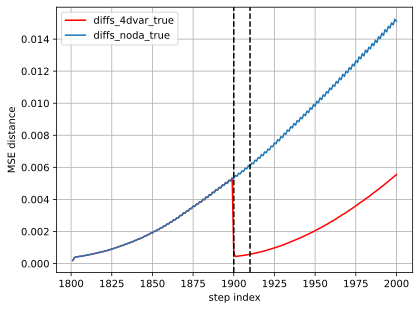

diffs_noda_real_mse[da_idxs[0]]=tensor(0.0053), diffs_noda_real_mse[da_idxs[1]]=tensor(0.0060)
diffs_da_real_mse[da_idxs[0]]=tensor(0.0007), diffs_da_real_mse[da_idxs[1]]=tensor(0.0006)
diffs_noda_real_rrmse[da_idxs[0]]=tensor(0.1382), diffs_noda_real_rrmse[da_idxs[1]]=tensor(0.1477)
diffs_da_real_rrmse[da_idxs[0]]=tensor(0.0488), diffs_da_real_rrmse[da_idxs[1]]=tensor(0.0456)
diffs_noda_real_ssim[da_idxs[0]]=0.7700207779647984, diffs_noda_real_ssim[da_idxs[1]]=0.7408145560704971
diffs_da_real_ssim[da_idxs[0]]=0.9468896733098592, diffs_da_real_ssim[da_idxs[1]]=0.9563728125675113


In [54]:
step_idxs = list(range(start_da_end_idxs[0] + 1, start_da_end_idxs[-1] + 1))

plt.plot(step_idxs, diffs_da_real_mse, color="r", label="diffs_4dvar_true")
plt.plot(step_idxs, diffs_noda_real_mse, color="#1f77b4", label="diffs_noda_true")
for x in time_obs:
    plt.axvline(x=x, color="k", linestyle="--")
plt.xlabel("step index")
plt.ylabel("MSE distance")
plt.grid(True)
plt.legend()

plt.show()

da_idxs = [99, 109]
print(f"{diffs_noda_real_mse[da_idxs[0]]=}, {diffs_noda_real_mse[da_idxs[1]]=}")
print(f"{diffs_da_real_mse[da_idxs[0]]=}, {diffs_da_real_mse[da_idxs[1]]=}")
print(f"{diffs_noda_real_rrmse[da_idxs[0]]=}, {diffs_noda_real_rrmse[da_idxs[1]]=}")
print(f"{diffs_da_real_rrmse[da_idxs[0]]=}, {diffs_da_real_rrmse[da_idxs[1]]=}")
print(f"{diffs_noda_real_ssim[da_idxs[0]]=}, {diffs_noda_real_ssim[da_idxs[1]]=}")
print(f"{diffs_da_real_ssim[da_idxs[0]]=}, {diffs_da_real_ssim[da_idxs[1]]=}")

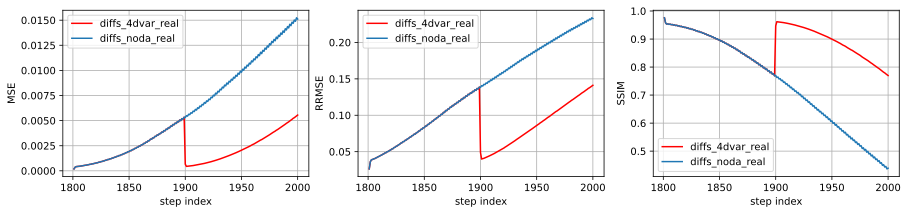

In [55]:
step_idxs = list(range(start_da_end_idxs[0] + 1, start_da_end_idxs[-1] + 1))
da_points = [1900]

_, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].plot(step_idxs, diffs_da_real_mse, color="r", label="diffs_4dvar_real")
ax[0].plot(step_idxs, diffs_noda_real_mse, color="#1f77b4", label="diffs_noda_real")

ax[1].plot(step_idxs, diffs_da_real_rrmse, color="r", label="diffs_4dvar_real")
ax[1].plot(step_idxs, diffs_noda_real_rrmse, color="#1f77b4", label="diffs_noda_real")

ax[2].plot(step_idxs, diffs_da_real_ssim, color="r", label="diffs_4dvar_real")
ax[2].plot(step_idxs, diffs_noda_real_ssim, color="#1f77b4", label="diffs_noda_real")

for i, name in enumerate(["MSE", "RRMSE", "SSIM"]):
    ax[i].set_xlabel("step index")
    ax[i].set_ylabel(name)
    ax[i].grid(True)
    ax[i].legend()
    # for x in da_points:
    #     ax[i].axvline(x=x, color="k", linestyle="--")

plt.show()

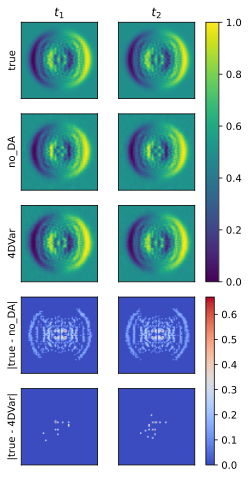

In [56]:
da_idxs = [99, 109]

fig, ax = plt.subplots(5, len(da_idxs), figsize=(2 * len(da_idxs), 8), sharex=True)
for x in ax.flat:
    x.set_xticks([])
    x.set_yticks([])
    x.set_xticklabels([])
    x.set_yticklabels([])
# outs --> no DA list [39, Shape([1, 5, 32])]
# outs_da --> has DA list [39, Shape([1, 5, 32])]

u_decoder = u_decoder.to(device)
u_decoder.eval()
setup_cmap = True
with torch.no_grad():
    for i, da_idx in enumerate(da_idxs):
        img_tensor = transform(
            Image.open(
                f"data/u_64R_8000/{time_obs[i]}.png"
            )
        )
        im1 = ax[0, i].imshow(torch.reshape(img_tensor, (64, 64)), origin="lower", cmap="viridis")
        if setup_cmap:
            # Create a ScalarMappable object with the colormap from images
            sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)
        no_da = u_decoder(outs_no_4d_da[da_idx][:, 0]).cpu()
        da = u_decoder(outs_4d_da[da_idx][:, 0]).cpu()
        ax[1, i].imshow(torch.reshape(no_da, (64, 64)), origin="lower", cmap="viridis")
        ax[2, i].imshow(torch.reshape(da, (64, 64)), origin="lower", cmap="viridis")
        res = (img_tensor.reshape((64, 64)) - no_da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        im2 = ax[3, i].imshow(res, origin="lower", cmap="coolwarm")
        if setup_cmap:
            sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
        res = (img_tensor.reshape((64, 64)) - da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        ax[4, i].imshow(res, origin="lower", cmap="coolwarm")
        setup_cmap = False

for i, title in enumerate(["$t_1$", "$t_2$"]):
    ax[0, i].set_title(title)
# ax[0].set_title("$t$")
for i, ylabel in enumerate(["true", "no_DA", "4DVar", "|true - no_DA|", "|true - 4DVar|"]):
    ax[i, 0].set_ylabel(ylabel)

# # Create a ScalarMappable object with the colormap from images
# sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm1.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
# fig.colorbar(sm1, ax=ax, orientation="vertical")

fig.colorbar(sm1, ax=ax[:-2, :], orientation="vertical")
sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[-2:, :], orientation="vertical")

plt.show()